<a href="https://colab.research.google.com/github/AlonResearch/SNN-for-MI-EEG/blob/main/MI3_SNNforMIeeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
from pathlib import Path
import numpy as np
import torch
import torch.utils.data as da
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import scipy.io as scio
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:


# Get cpu or gpu device for training.
print(torch.__version__, torch.cuda.is_available(), torch.version.cuda)
print(sys.version)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
!nvidia-smi

2.5.1+cu124 True 12.4
3.11.12 (main, May 22 2025, 01:56:58) [MSC v.1943 64 bit (AMD64)]
Using cuda device
Fri Dec 19 11:10:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.80                 Driver Version: 581.80         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:64:00.0  On |                  N/A |
| N/A   36C    P5              5W /  100W |    1823MiB /   6141MiB |     11%      Default |
|                                 

In [3]:
# @title Data loader and other functions
#Defining functions

def data_loader(data, label, batch=64, shuffle=True, drop=False):
    """
    Preprocess the data to fit model.
    Feed data into data_loader.
    input:
        data (float): samples*length*ch (samples*ch*length).
        label (int): samples, ie.: [0, 1, 1, 0, ..., 2].
        batch (int): batch size
        shuffle (bool): shuffle data before input into decoder
        drop (bool): drop the last samples if True
    output:
        data loader
    """
    label = torch.LongTensor(label.flatten()).to(device)
    if data.shape[1] >= data.shape[2]:
        data = torch.tensor(data.swapaxes(1, 2))
    data = torch.unsqueeze(data, dim=1).type('torch.FloatTensor').to(device)
    data = da.TensorDataset(data, label)
    loader = da.DataLoader(dataset=data, batch_size=batch, shuffle=shuffle, drop_last=drop)
    return loader

torch.backends.cudnn.benchmark = True

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
        elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)


def train_ann(cnn_model, train_x, train_y, test_x, test_y, ep=500, batch=64):
    """
    input:
        train_x, test_x (float): samples*length*ch (samples*ch*length).
        train_y, test_y (int): samples, ie.: [0, 1, 1, 0, ..., 2].
        ep (int): total train and test epoch
        batch (int): batch size
    output:
        train acc, test acc, weight_file
    """
    # Define training configuration
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.01)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ep)

    # Define data loader
    train_loader = data_loader(train_x, train_y, batch=batch)
    test_loader = data_loader(test_x, test_y, batch=batch)

    train_acc = []
    test_acc = []
    for epoch in range(ep):
        # Train ANN
        cnn_model.train()
        train_loss = 0
        correct = 0
        total = 0
        loss = 0
        print('\n')
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = cnn_model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            print(batch_idx, len(train_loader), 'Epoch: %d | ANN: trainLoss: %.4f | trainAcc: %.4f%% (%d/%d)'
                  % (epoch, train_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        lr_scheduler.step()
        train_acc.append(round(correct / total, 4))

        # Test ANN
        cnn_model.eval()
        val_loss = 0
        correct = 0
        total = 0
        loss = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):
                outputs = cnn_model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                print(batch_idx, len(test_loader), 'Epoch: %d | ANN: testLoss: %.4f | testAcc: %.4f%% (%d/%d)'
                      % (epoch, val_loss / (batch_idx + 1), 100. * correct / total, correct, total))

        test_acc.append(round(correct / total, 4))

    train_acc = np.asarray(train_acc[-1])
    test_acc = np.asarray(test_acc[-1])
    return train_acc, test_acc,cnn_model

In [4]:
# @title Model definitions
# Model 2a

class LENet(nn.Module):
    """
        LENet Model
    input:
         data shape as: batch_size*1*channel*length (64*1*22*1000) BCI IV-2a
         batch_size：64
         channel：22
         length：1000
    output:
        classes_num
    """

    def __init__(self, classes_num=3, channel_count=22, drop_out = 0.5):
        super(LENet, self).__init__()
        self.drop_out = drop_out

        self.block_TCB_1 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,64) #
            nn.ZeroPad2d((32, 31, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 64),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_2 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,32) #
            nn.ZeroPad2d((16, 15, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 32),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_3 = nn.Sequential(
            # Temporal Convolution block kernel_size (1,16) #
            nn.ZeroPad2d((8, 7, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 16),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )

        self.TCB_fusion = nn.Sequential(
            # Temporal Convolution block fusion kernel_size (1,1) #
            nn.Conv2d(
                in_channels=24,
                out_channels=24,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(24)
        )

        self.SCB = nn.Sequential(
            # Spatial Convolution block kernel_size (channel,1) #
            nn.Conv2d(
                in_channels=24,
                out_channels=16,
                kernel_size=(channel_count, 1),
                groups=8,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_out)
        )

        self.FFCB = nn.Sequential(
            # Feature Fusion Convolution block kernel_size (1,16) and (1,1) #
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 16),
                groups=16,
                bias=False
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 1),
                bias=False
            ),  #
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_out)
        )

        self.CCB = nn.Sequential(
            # Classification Convolution block kernel_size (1,1) #
            nn.Conv2d(
                in_channels=16,
                out_channels=classes_num,
                kernel_size=(1, 1),
                bias=False
            ),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

    def forward(self, x):
        x1 = self.block_TCB_1(x)
        x2 = self.block_TCB_2(x)
        x3 = self.block_TCB_3(x)
        x4 = torch.cat([x1, x2, x3], dim=1)
        x = self.TCB_fusion(x4)
        x = self.SCB(x)
        x = self.FFCB(x)
        x = self.CCB(x)
        return x

class LENet_FCL(nn.Module):
    def __init__(self, classes_num=3, channel_count=60, drop_out=0.5):
        super(LENet_FCL, self).__init__()
        self.drop_out = drop_out

        # Keep all the convolutional layers the same
        self.block_TCB_1 = nn.Sequential(
            nn.ZeroPad2d((32, 31, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 64),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_2 = nn.Sequential(
            nn.ZeroPad2d((16, 15, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 32),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )
        self.block_TCB_3 = nn.Sequential(
            nn.ZeroPad2d((8, 7, 0, 0)),
            nn.Conv2d(
                in_channels=1,
                out_channels=8,
                kernel_size=(1, 16),
                bias=False,
            ),
            nn.BatchNorm2d(8)
        )

        self.TCB_fusion = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=24,
                kernel_size=(1, 1),
                bias=False,
            ),
            nn.BatchNorm2d(24)
        )

        self.SCB = nn.Sequential(
            nn.Conv2d(
                in_channels=24,
                out_channels=16,
                kernel_size=(channel_count, 1),
                groups=8,
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(self.drop_out)
        )

        self.FFCB = nn.Sequential(
            nn.ZeroPad2d((7, 8, 0, 0)),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 16),
                groups=16,
                bias=False
            ),
            nn.Conv2d(
                in_channels=16,
                out_channels=16,
                kernel_size=(1, 1),
                bias=False
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(self.drop_out)
        )

        # We'll determine the size of the FC layer in the forward pass
        self.flatten = nn.Flatten()
        self.fc = None
        self.classes_num = classes_num

    def forward(self, x):
        x1 = self.block_TCB_1(x)
        x2 = self.block_TCB_2(x)
        x3 = self.block_TCB_3(x)
        x4 = torch.cat([x1, x2, x3], dim=1)
        x = self.TCB_fusion(x4)
        x = self.SCB(x)
        x = self.FFCB(x)

        # Flatten the output
        x = self.flatten(x)

        # Create the FC layer on first forward pass if it doesn't exist
        if self.fc is None:
            in_features = x.shape[1]
            self.fc = nn.Linear(in_features, self.classes_num).to(x.device)
            # Initialize weights for the new layer
            nn.init.kaiming_normal_(self.fc.weight, mode="fan_out", nonlinearity="relu")
            if self.fc.bias is not None:
                nn.init.constant_(self.fc.bias, 0)

        # Apply the FC layer
        x = self.fc(x)
        return x

In [12]:
# @title Loading the data
"""
Loading the data
"""

# Getting real samples
# Locally load the dataset
proj_path = Path.cwd().parent
mat_path = proj_path / "Datasets/MI3/derivatives/sub-011_eeg90hz.mat"
if not mat_path.exists():
    raise FileNotFoundError(f"Dataset not found at: {mat_path}")

print(f"Loading dataset from: {mat_path}")
file = scio.loadmat(mat_path)

# Google Colab load the dataset
# file = scio.loadmat('/content/sub-013_eeg90hz_7-35.mat')


all_data = file['all_data']
all_label = file['all_label']
REDUCE_REST = 1

# Print data information
channel_count = all_data.shape[1]
num_classes = len(np.unique(all_label.flatten()))
data_length = all_data.shape[2] # Assuming data is samples*ch*length
print(f"Channel count: {channel_count}")
print(f"Data shape: {all_data.shape}")
print(f"Label shape: {all_label.shape}")
print(f"Class distribution: Rest: {np.sum(all_label == 0)}, Elbow: {np.sum(all_label == 1)}, Hand: {np.sum(all_label == 2)}")

# Address class imbalance for 'Rest' class (label 0)
label_0_indices = np.where(all_label.flatten() == 0)[0]
label_other_indices = np.where(all_label.flatten() != 0)[0]

# Randomly select "REDUCE_REST"% of label 0 indices
num_label_0_to_keep = int(len(label_0_indices) * REDUCE_REST)
#np.random.seed(42) # for reproducibility
selected_label_0_indices = np.random.choice(label_0_indices, size=num_label_0_to_keep, replace=False)

# Combine selected label 0 indices with all other labels
balanced_indices = np.concatenate((selected_label_0_indices, label_other_indices))
np.random.shuffle(balanced_indices) # Shuffle the combined dataset

all_data_balanced = all_data[balanced_indices]
all_label_balanced = all_label[balanced_indices]

print(f"Balanced class distribution: Rest: {np.sum(all_label_balanced == 0)}, Elbow: {np.sum(all_label_balanced == 1)}, Hand: {np.sum(all_label_balanced == 2)}")
print(f"Balanced data shape: {all_data_balanced.shape}")
print(f"Balanced label shape: {all_label_balanced.shape}")

datasetX = torch.tensor(all_data_balanced, dtype=torch.float32)
datasetY = torch.tensor(all_label_balanced, dtype=torch.int64)


Loading dataset from: d:\OneDrive - unb.br\Bar-Ilan\Machine Learning\MI-EEG-Final-ML-Proj\Datasets\MI3\derivatives\sub-011_eeg90hz.mat
Channel count: 62
Data shape: (965, 62, 360)
Label shape: (965, 1)
Class distribution: Rest: 365, Elbow: 300, Hand: 300
Balanced class distribution: Rest: 365, Elbow: 300, Hand: 300
Balanced data shape: (965, 62, 360)
Balanced label shape: (965, 1)


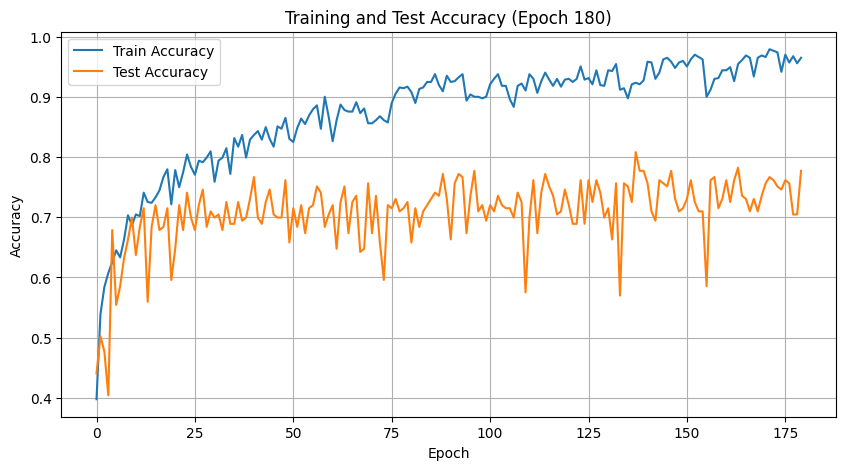

Epoch: 179 | Train Loss: 0.2143 | Train Acc: 96.50% | Test Loss: 0.6578 | Test Acc: 77.72%
Epoch: 180 | Train Loss: 0.3083 | Train Acc: 89.38% | Test Loss: 2.3644 | Test Acc: 50.26%
Epoch: 181 | Train Loss: 0.4386 | Train Acc: 87.69% | Test Loss: 0.4821 | Test Acc: 74.61%
Epoch: 182 | Train Loss: 0.3255 | Train Acc: 92.10% | Test Loss: 0.6556 | Test Acc: 74.09%
Epoch: 183 | Train Loss: 0.1628 | Train Acc: 91.71% | Test Loss: 0.6271 | Test Acc: 75.13%
Epoch: 184 | Train Loss: 0.2614 | Train Acc: 93.39% | Test Loss: 0.5599 | Test Acc: 77.72%
Epoch: 185 | Train Loss: 0.1929 | Train Acc: 93.65% | Test Loss: 0.4903 | Test Acc: 76.68%
Epoch: 186 | Train Loss: 0.1722 | Train Acc: 92.88% | Test Loss: 1.2016 | Test Acc: 68.39%
Epoch: 187 | Train Loss: 0.2996 | Train Acc: 93.78% | Test Loss: 0.6011 | Test Acc: 74.61%
Early stopping triggered at epoch 188


ANN accuracy: Test: 74.6114%


NameError: name 'proj_path' is not defined

In [ ]:

# @title LENet Framework execution


# Hyperparameters
EPOCHS = 1000
BATCH_SIZE = 64
TEST_SIZE = 0.2
DROP_OUT = 0.35


# Split the data
print(f"{100 - (TEST_SIZE * 100)}% of the dataset is used for training and {TEST_SIZE * 100}% is used for testing.")
train_data, test_data, train_label, test_label = train_test_split(datasetX, datasetY, test_size=TEST_SIZE, shuffle=True,
                                                                  random_state=0)

# Initialize model
cnn_model_lenet_ccb = LENet(classes_num=3, channel_count=channel_count, drop_out = DROP_OUT).to(device)
cnn_model_lenet_ccb.apply(initialize_weights)

# Train CNN model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model_lenet_ccb.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

train_loader = data_loader(train_data, train_label, batch=BATCH_SIZE)
test_loader = data_loader(test_data, test_label, batch=BATCH_SIZE)

class EarlyStopper:
    def __init__(self, patience=40, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -np.inf
        self.counter = 0

    def step(self, metric):
        if metric - self.best_metric > self.min_delta:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopper = EarlyStopper(patience=50, min_delta=5e-4)
train_hist, test_hist = [], []

for epoch in range(EPOCHS):
    cnn_model_lenet_ccb.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = cnn_model_lenet_ccb(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    lr_scheduler.step()
    train_hist.append(correct / total)

    cnn_model_lenet_ccb.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = cnn_model_lenet_ccb(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_hist.append(correct / total)

    # Real-time plotting
    if (epoch + 1) % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_hist, label='Train Accuracy')
        plt.plot(test_hist, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Training and Test Accuracy (Epoch {epoch + 1})')
        plt.grid(True)
        plt.show()

    print(f"Epoch: {epoch} | Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_hist[-1]*100:.2f}% | Test Loss: {val_loss/len(test_loader):.4f} | Test Acc: {test_hist[-1]*100:.2f}%")

    if early_stopper.step(test_hist[-1]):
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

train_acc = np.asarray(train_hist[-1])
test_acc = np.asarray(test_hist[-1])
print('\n')
print('ANN accuracy: Test: %.4f%%' % (test_acc * 100))


In [ ]:
# @title Save the model weights

torch.save(cnn_model_lenet_ccb.state_dict(), proj_path/'ModelWeights/lenet_ccb_mi3.pth')

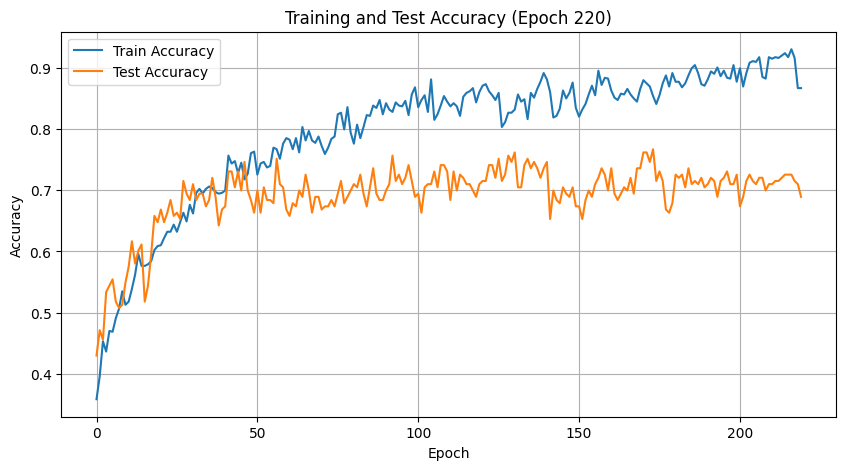

Epoch: 219 | Train Loss: 0.3799 | Train Acc: 86.66% | Test Loss: 0.5377 | Test Acc: 68.91%
Epoch: 220 | Train Loss: 0.2880 | Train Acc: 87.69% | Test Loss: 0.4940 | Test Acc: 69.43%
Epoch: 221 | Train Loss: 0.3100 | Train Acc: 87.31% | Test Loss: 0.7281 | Test Acc: 68.91%
Epoch: 222 | Train Loss: 0.2260 | Train Acc: 90.67% | Test Loss: 0.6378 | Test Acc: 72.54%
Epoch: 223 | Train Loss: 0.2137 | Train Acc: 91.97% | Test Loss: 0.5866 | Test Acc: 72.54%
Early stopping triggered at epoch 224


ANN accuracy: Test: 72.5389%


In [ ]:
# @title LENet_FCL framework execution

# Hyperparameters
#EPOCHS = 300
#BATCH_SIZE = 128
#TEST_SIZE = 0.2
#DROP_OUT = 0.5


# Split the data
print(f"{100 - (TEST_SIZE * 100)}% of the dataset is used for training and {TEST_SIZE * 100}% is used for testing.")
train_data, test_data, train_label, test_label = train_test_split(datasetX, datasetY, test_size=TEST_SIZE, shuffle=True,
                                                                  random_state=0)

# Initialize model
cnn_model_lenet_fcl = LENet_FCL(classes_num=3, channel_count=channel_count, drop_out = DROP_OUT).to(device)
cnn_model_lenet_fcl.apply(initialize_weights)

# Train CNN model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model_lenet_fcl.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

train_loader = data_loader(train_data, train_label, batch=BATCH_SIZE)
test_loader = data_loader(test_data, test_label, batch=BATCH_SIZE)

early_stopper = EarlyStopper(patience=50, min_delta=5e-4)
train_hist, test_hist = [], []

for epoch in range(EPOCHS):
    cnn_model_lenet_fcl.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = cnn_model_lenet_fcl(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    lr_scheduler.step()
    train_hist.append(correct / total)

    cnn_model_lenet_fcl.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            outputs = cnn_model_lenet_fcl(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_hist.append(correct / total)

    # Real-time plotting
    if (epoch + 1) % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(train_hist, label='Train Accuracy')
        plt.plot(test_hist, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Training and Test Accuracy (Epoch {epoch + 1})')
        plt.grid(True)
        plt.show()

    print(f"Epoch: {epoch} | Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_hist[-1]*100:.2f}% | Test Loss: {val_loss/len(test_loader):.4f} | Test Acc: {test_hist[-1]*100:.2f}%")

    if early_stopper.step(test_hist[-1]):
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break

train_acc = np.asarray(train_hist[-1])
test_acc = np.asarray(test_hist[-1])
print('\n')
print('ANN accuracy: Test: %.4f%%' % (test_acc * 100))


In [ ]:

# @title Save the model weights
torch.save(cnn_model_lenet_fcl.state_dict(), proj_path/'ModelWeights/lenet_fcl_mi3.pth')

In [9]:
# @title Evaluate models

# Prepare data loader for evaluation (using test_data from the last split)
eval_test_loader = data_loader(test_data, test_label, batch=BATCH_SIZE, shuffle=False, drop=False)

true_labels_list = []
for _, targets_batch in eval_test_loader:
    true_labels_list.extend(targets_batch.cpu().numpy())
true_labels_np = np.array(true_labels_list)

# --- 1. Get predictions for ANN models only ---
print("Generating predictions for ANN models...")
all_model_predictions = {}
model_objects = {
    "LENet CNN": cnn_model_lenet_ccb,
    "LENet_FCL CNN": cnn_model_lenet_fcl,
}

for model_name, model_obj in model_objects.items():
    print(f"Evaluating {model_name}...")
    model_obj.eval().to(device)
    current_preds = []

    with torch.no_grad():
        for inputs, _ in eval_test_loader:
            inputs = inputs.to(device)
            outputs = model_obj(inputs)
            _, predicted = outputs.max(1)
            current_preds.extend(predicted.cpu().numpy())

    all_model_predictions[model_name] = current_preds
print("All predictions generated.")

# --- 2. Calculate Accuracies for all models ---
accuracy_results = {}
class_names = ['Rest', 'Elbow', 'Hand']  # Corresponds to labels 0, 1, 2

for model_name, predictions in all_model_predictions.items():
    overall_acc = accuracy_score(true_labels_np, predictions)
    accuracy_results[model_name] = {"Overall": overall_acc}
    for class_idx, class_name_key in enumerate(class_names):
        class_indices = np.where(true_labels_np == class_idx)[0]
        if len(class_indices) > 0:
            class_true = true_labels_np[class_indices]
            class_pred = np.array(predictions)[class_indices]
            class_acc = accuracy_score(class_true, class_pred)
            accuracy_results[model_name][class_name_key] = class_acc
        else:
            accuracy_results[model_name][class_name_key] = np.nan

for model_name in all_model_predictions:
    print(model_name, end="|")


Generating predictions for ANN models...
Evaluating LENet CNN...
Evaluating LENet_FCL CNN...
All predictions generated.
LENet CNN|LENet_FCL CNN|

--- Experiment Configuration & Data Specifications ---
+-----------------------------------+-----------------------------------------+
| Parameter                          | Value                                    |
+===================================+=========================================+
| Dataset File                       | sub-011_eeg.mat                          |
| EEG Channels                       | 62                                       |
| Data Shape (Full Dataset)          | Samples: 965, Channels: 62, Length: 360  |
| Class Distribution (Full Dataset)  | Rest: 365, Elbow: 300, Hand: 300         |
| Bandpass Filter (Reported)         | 7-35Hz                                   |
| Sampling Ratio (Reported)          | 90Hz                                     |
| TRAINING EPOCHS                    | 1000                                     |
| Dropout                            | 0.35                                     |
| Test Split                         | 0.2     

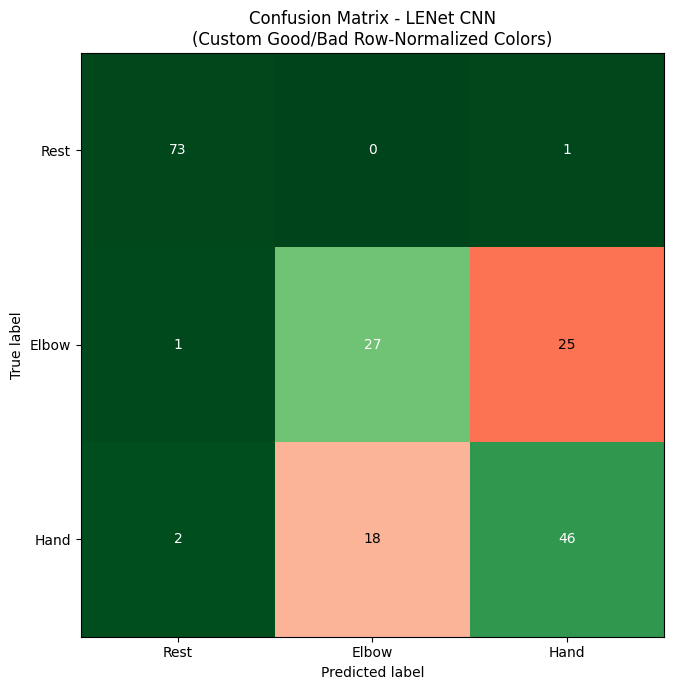


Figure 1: Confusion Matrix for LENet CNN.
This matrix visualizes classification performance with custom colors based on row-normalized values
Overall Accuracy: 75.65%.
Accuracy for Rest: 98.65%.
Accuracy for Elbow: 50.94%.
Accuracy for Hand: 69.70%.
----------------------------------------------------------------------


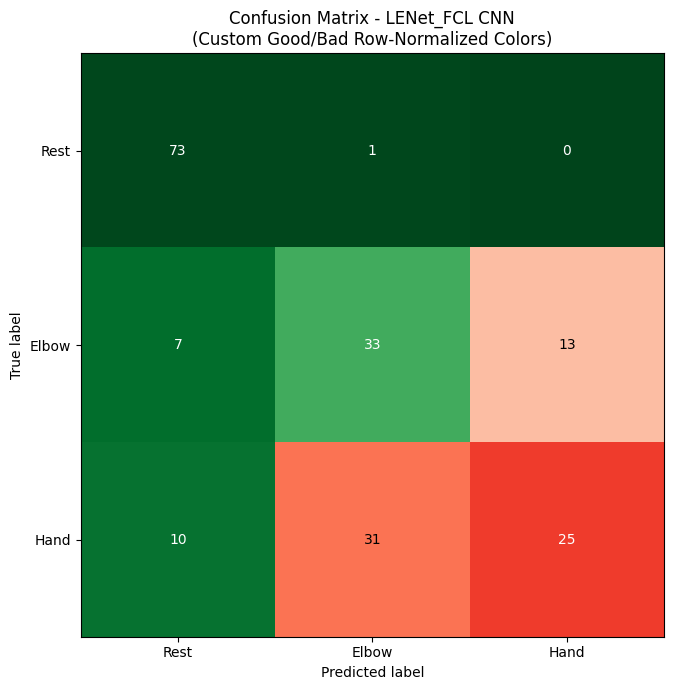


Figure 2: Confusion Matrix for LENet_FCL CNN.
This matrix visualizes classification performance with custom colors based on row-normalized values
Overall Accuracy: 67.88%.
Accuracy for Rest: 98.65%.
Accuracy for Elbow: 62.26%.
Accuracy for Hand: 37.88%.
----------------------------------------------------------------------


--- Model Performance Summary Table ---
| Model             | Overall Acc.    | Rest Acc.    | Elbow Acc.   | Hand Acc.    |
|-------------------|-----------------|--------------|--------------|--------------|
| LENet CNN         | 75.65%          | 98.65%       | 50.94%       | 69.70%       |
| LENet_FCL CNN     | 67.88%          | 98.65%       | 62.26%       | 37.88%       |


In [10]:
# @title visualize results (Custom confusion matrix, green good, red bad)
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib # For colormaps access

# Ensure all necessary variables from previous cells are available:
# cnn_model_lenet_ccb, cnn_model_lenet_fcl
# test_data, test_label (from the last train_test_split)
# EPOCHS, DROP_OUT, TEST_SIZE, BATCH_SIZE, device (from training blocks)
# channel_count, num_classes, data_length (from data loading cell)
# all_data, all_label (from data loading cell, for full dataset stats)
# all_model_predictions, accuracy_results, true_labels_np (from previous evaluation steps)
# data_loader function (defined in a previous cell)

# --- 0. Report Header: Hyperparameters and Data Specifications (Table Format) ---
print("--- Experiment Configuration & Data Specifications ---")

config_params = {
    "Dataset File": "sub-011_eeg.mat",
    "EEG Channels": channel_count if 'channel_count' in locals() else "N/A",
    "Data Shape (Full Dataset)": (
        f"Samples: {all_data.shape[0]}, Channels: {all_data.shape[1]}, Length: {all_data.shape[2]}"
        if 'all_data' in locals() and hasattr(all_data, 'shape') and len(all_data.shape) == 3
        else "N/A"),
    "Class Distribution (Full Dataset)": (
        f"Rest: {np.sum(all_label == 0)}, "
        f"Elbow: {np.sum(all_label == 1)}, "
        f"Hand: {np.sum(all_label == 2)}"
    ) if 'all_label' in locals() and isinstance(all_label, np.ndarray) and all_label.ndim >=1 else "N/A",
    "Bandpass Filter (Reported)": "7-35Hz",
    "Sampling Ratio (Reported)": "90Hz",
    "TRAINING EPOCHS": EPOCHS if 'EPOCHS' in locals() else "N/A",
    "Dropout": DROP_OUT if 'DROP_OUT' in locals() else "N/A",
    "Test Split": TEST_SIZE if 'TEST_SIZE' in locals() else "N/A",
    "Batch Size (Evaluation)": BATCH_SIZE if 'BATCH_SIZE' in locals() else "N/A"
}

max_key_len = max(len(key) for key in config_params.keys())
str_config_values = [str(val) for val in config_params.values()]
max_val_len = max(len(val) for val in str_config_values)

key_col_width = max_key_len + 2
val_col_width = max_val_len + 2

print("+" + "-" * (key_col_width) + "+" + "-" * (val_col_width) + "+")
print(f"| {'Parameter':<{key_col_width-1}} | {'Value':<{val_col_width-1}} |")
print("+" + "=" * (key_col_width) + "+" + "=" * (val_col_width) + "+")

for idx, (key, value) in enumerate(config_params.items()):
    print(f"| {key:<{key_col_width-1}} | {str(value):<{val_col_width-1}} |")

print("+" + "-" * (key_col_width) + "+" + "-" * (val_col_width) + "+")
print("\n")

print("\n--- Confusion Matrices and Descriptions ---")
class_names_display = ['Rest', 'Elbow', 'Hand']
figure_counter = 1

try:
    cmap_greens = matplotlib.colormaps['Greens']
    cmap_reds = matplotlib.colormaps['Reds']
except AttributeError:
    cmap_greens = plt.cm.get_cmap('Greens')
    cmap_reds = plt.cm.get_cmap('Reds')

threshold_diagonal_good = 0.5
threshold_off_diagonal_bad = 0.2

if 'all_model_predictions' in locals() and 'true_labels_np' in locals() and 'accuracy_results' in locals():
    for model_name, predictions in all_model_predictions.items():
        cm = confusion_matrix(true_labels_np, predictions, labels=range(len(class_names_display)))

        row_sums = cm.sum(axis=1, keepdims=True)
        cm_normalized_row = np.zeros_like(cm, dtype=float)
        for r_idx in range(cm.shape[0]):
            if row_sums[r_idx, 0] > 0:
                cm_normalized_row[r_idx, :] = cm[r_idx, :] / row_sums[r_idx, 0]

        num_classes_cm = cm.shape[0]
        color_matrix_rgb = np.zeros((num_classes_cm, num_classes_cm, 3))
        colormap_input_values = np.zeros((num_classes_cm, num_classes_cm))

        for i in range(num_classes_cm):
            for j in range(num_classes_cm):
                norm_value = cm_normalized_row[i, j]
                color_val_for_cmap = 0.0

                if row_sums[i, 0] == 0:
                    color_matrix_rgb[i, j, :] = [0.95, 0.95, 0.95]
                elif i == j:
                    if norm_value > threshold_diagonal_good:
                        color_val_for_cmap = norm_value
                        color_matrix_rgb[i, j, :] = cmap_greens(color_val_for_cmap)[:3]
                    else:
                        color_val_for_cmap = 1.0 - norm_value
                        color_matrix_rgb[i, j, :] = cmap_reds(color_val_for_cmap)[:3]
                else:
                    if norm_value > threshold_off_diagonal_bad:
                        color_val_for_cmap = norm_value
                        color_matrix_rgb[i, j, :] = cmap_reds(color_val_for_cmap)[:3]
                    else:
                        color_val_for_cmap = 1.0 - norm_value
                        color_matrix_rgb[i, j, :] = cmap_greens(color_val_for_cmap)[:3]
                colormap_input_values[i, j] = color_val_for_cmap

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_display)
        fig, ax = plt.subplots(figsize=(8, 7))
        disp.plot(ax=ax, include_values=True, cmap='Greys', colorbar=False, values_format='d')

        if ax.images:
            ax.images[0].remove()
        ax.imshow(color_matrix_rgb)

        if disp.text_ is not None:
            for i in range(num_classes_cm):
                for j in range(num_classes_cm):
                    if disp.text_[i, j] is not None:
                        text_color = "white" if colormap_input_values[i, j] > 0.5 else "black"
                        if row_sums[i, 0] == 0:
                            text_color = "black"
                        disp.text_[i, j].set_color(text_color)

        ax.set_title(f'Confusion Matrix - {model_name}\n(Custom Good/Bad Row-Normalized Colors)')
        plt.tight_layout()
        plt.show()

        print(f"\nFigure {figure_counter}: Confusion Matrix for {model_name}.")
        print("This matrix visualizes classification performance with custom colors based on row-normalized values")

        class_names_for_acc = ['Rest', 'Elbow', 'Hand']
        overall_acc_val = accuracy_results[model_name]['Overall'] * 100
        print(f"Overall Accuracy: {overall_acc_val:.2f}%.")

        for class_idx, class_name_label in enumerate(class_names_display):
            current_class_key = class_names_for_acc[class_idx]
            if current_class_key in accuracy_results[model_name]:
                class_acc_val = accuracy_results[model_name][current_class_key]
                if not np.isnan(class_acc_val):
                    print(f"Accuracy for {class_name_label}: {class_acc_val*100:.2f}%.")
                else:
                    print(f"Accuracy for {class_name_label}: N/A (value is NaN).")
            else:
                print(f"Accuracy for {class_name_label}: N/A (key not found).")
        print("-" * 70)
        figure_counter += 1
else:
    print("Required variables (all_model_predictions, true_labels_np, or accuracy_results) not found for plotting confusion matrices.")

print("\n\n--- Model Performance Summary Table ---")
class_names_for_table = ['Rest', 'Elbow', 'Hand']

if 'accuracy_results' in locals():
    header = f"| {'Model':<17} | {'Overall Acc.':<15} | {class_names_for_table[0]+' Acc.':<12} | {class_names_for_table[1]+' Acc.':<12} | {class_names_for_table[2]+' Acc.':<12} |"
    separator = "|-------------------|-----------------|--------------|--------------|--------------|"
    print(header)
    print(separator)
    for model_name_key in accuracy_results:
        overall_str = f"{accuracy_results[model_name_key]['Overall']*100:.2f}%"

        rest_acc_val = accuracy_results[model_name_key].get(class_names_for_table[0], np.nan)
        rest_str = f"{rest_acc_val*100:.2f}%" if not np.isnan(rest_acc_val) else "N/A"

        elbow_acc_val = accuracy_results[model_name_key].get(class_names_for_table[1], np.nan)
        elbow_str = f"{elbow_acc_val*100:.2f}%" if not np.isnan(elbow_acc_val) else "N/A"

        hand_acc_val = accuracy_results[model_name_key].get(class_names_for_table[2], np.nan)
        hand_str = f"{hand_acc_val*100:.2f}%" if not np.isnan(hand_acc_val) else "N/A"

        row = f"| {model_name_key:<17} | {overall_str:<15} | {rest_str:<12} | {elbow_str:<12} | {hand_str:<12} |"
        print(row)
else:
    print("Accuracy results not available for summary table.")
